In [146]:
import os, sys, wave, struct

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import IPython

from copy import deepcopy
from math import ceil, exp, atan, pi, cos, sin
from scipy.io.wavfile import write
#import scipy.io.wavfile
from scipy.linalg import hankel
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import pylab as p
#import matplotlib.axes3d as p3
import mpl_toolkits.mplot3d.axes3d as p3

# Useful functions

In [147]:
def load_sound(file):
    return wave.open(file, 'rb')

def plot_sound(data, times,xlim1,xlim2,name='default_name', save=False,w=20,h=10, lw = 3):
    try :
        if len(data[0]) > 1:
            plt.figure(figsize=(w, h))
            for data_elem in data:
                plt.plot(times,data_elem.reshape(len(data_elem)))
            plt.xlim(xlim1,xlim2)
            plt.xlabel('time (s)')
            plt.ylabel('amplitude')
        else :
            plt.figure(figsize=(w, h))
            plt.plot(times,data.reshape(len(data)))
            plt.xlim(xlim1,xlim2)
            plt.xlabel('time (s)')
            plt.ylabel('amplitude')
            if save:
                plt.savefig(name+'.png', dpi=100)
        plt.show()
    except :
        plt.figure(figsize=(w, h))
        plt.plot(times,data.reshape(len(data)))
        plt.xlim(xlim1,xlim2)
        plt.xlabel('time (s)')
        plt.ylabel('amplitude')
        if save:
            plt.savefig(name+'.png', dpi=100)
        plt.show()
    
def read_values(filename):
    wave_file = wave.open(filename, 'r')
    nframes = wave_file.getnframes()
    nchannels = wave_file.getnchannels()
    sampling_frequency = wave_file.getframerate()
    T = nframes / float(sampling_frequency)
    read_frames = wave_file.readframes(nframes)
    wave_file.close()
    data = struct.unpack("%dh" %  nchannels*nframes, read_frames)
    
    data_per_channel = [data[offset::nchannels] for offset in range(nchannels)]
    return T, np.array(data_per_channel), nframes, nchannels, sampling_frequency

In [148]:
def Synthesis(N,delta,f,a,phi,RSB=False):
    t = range(N)
    logz = delta + 1j*2*np.pi*f
    alpha = np.array([a[k]*np.exp(1j*phi[k]) for k in range(len(a))])
    x = np.sum(np.outer(alpha, np.ones(N))*np.exp(np.outer(logz,t)), axis=0)
    if RSB == False: 
        s = x
    else: 
        Ex = np.real(np.sum(np.abs(x)**2))/N
        b = np.random.normal(size=N) + 1j*np.random.normal(size=N)
        Eb = np.real(np.sum(np.abs(b)**2))/N
        b = b*np.sqrt(Ex/Eb)*10**(-RSB/20)
        s = x+b    
    return s

# Open audio file

In [149]:
wavefile = load_sound('ClocheB.WAV')
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=8000, nframes=99414, comptype='NONE', compname='not compressed')


In [150]:
IPython.display.Audio('ClocheB.WAV')

In [151]:
T, data, nframes, nchannels, sampling_frequency = read_values('ClocheA.WAV')
Fs = int(wavefile.getframerate())
x = np.array(data)
num_samples = int(wavefile.getnframes())

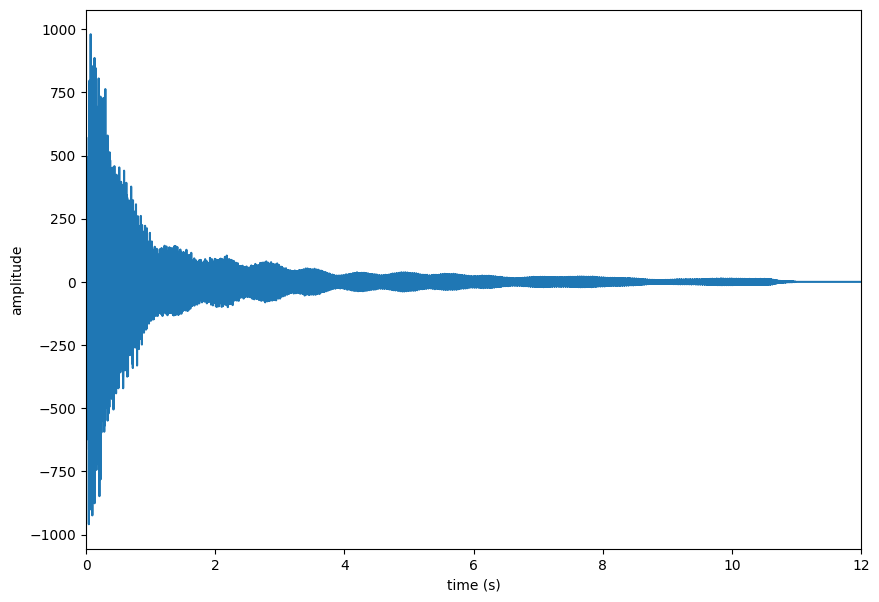

In [152]:
len_x = x.shape[1]
timestep = 1/(float(Fs))
times = np.arange(len_x)*timestep # int(len_x/6)
plot_sound(x.reshape(len_x), times,0,12,w=10,h=7)

In [153]:
write('new_bell.wav', Fs, np.array(x.reshape(len_x), dtype=np.int16)) # to write a new wave file

---

# 3. Synthetiser le signal 

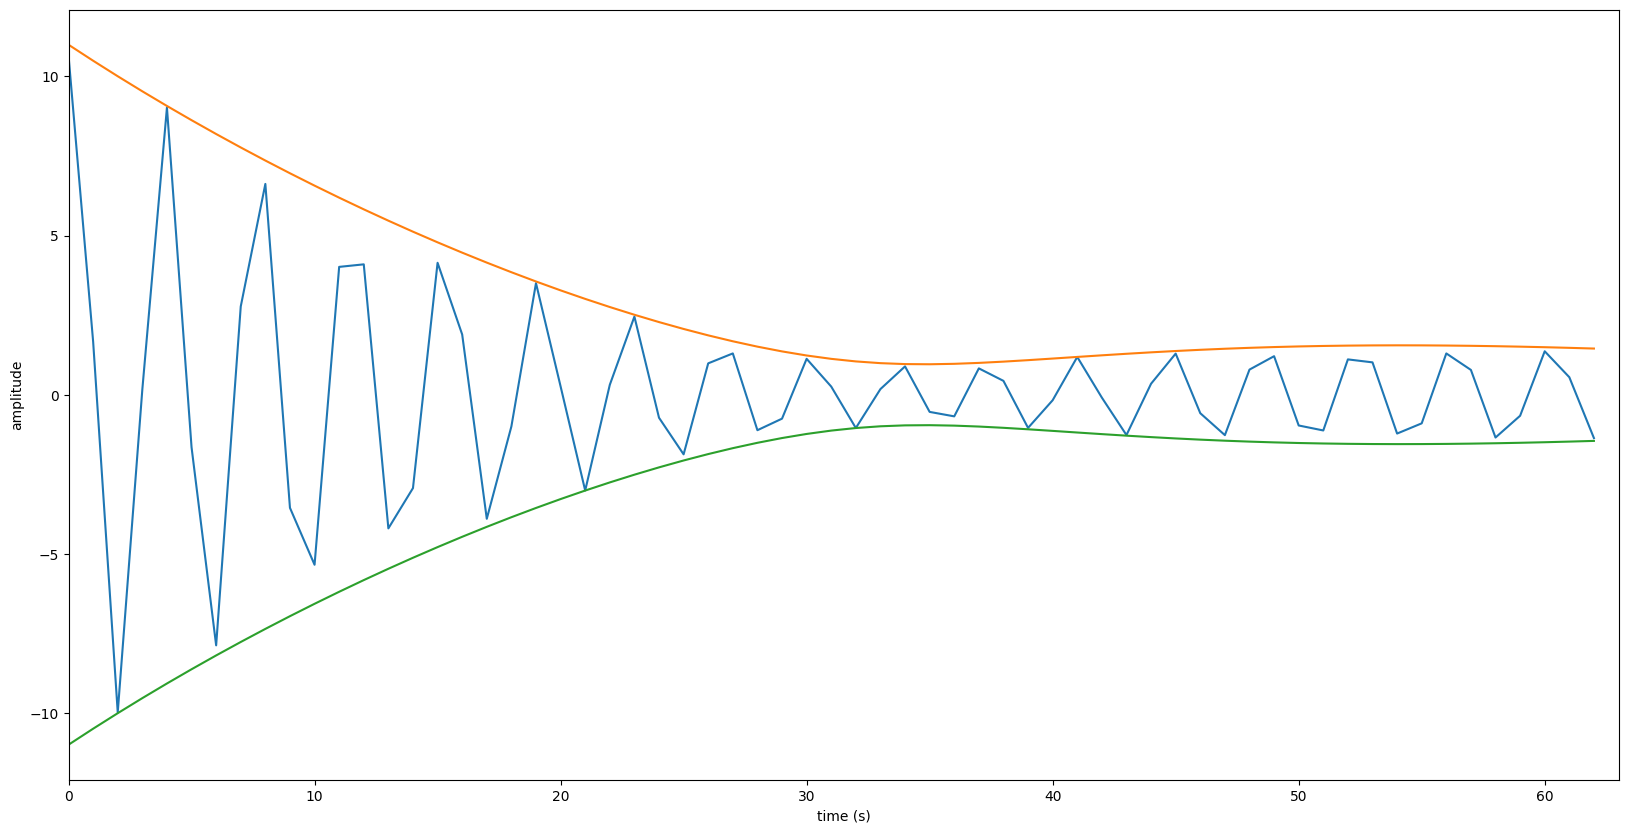

[-0.3564268203054106, -0.2391373403616912]


In [154]:
delta = np.array([0,-0.05])
N=63
f=np.array([1/4,1/4 + 1/N])
a=np.array([1,10])
phi=[np.random.uniform(-np.pi,np.pi),np.random.uniform(-np.pi,np.pi)]
x=Synthesis(N,delta,f,a,phi)
times = np.arange(N) # int(len_x/6)
plot_sound([np.real(x),abs(x),-abs(x)],times,0,N)
print(phi)

---

## 3.1) Spectral analysis by Fourier transform

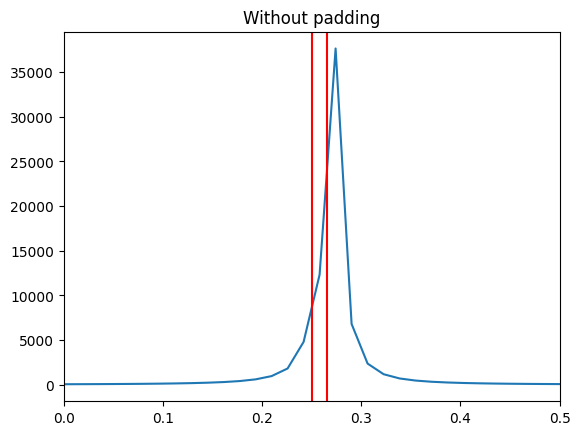

In [155]:
Nfft = N
fig, ax = plt.subplots()
plt.xlim([0,0.5])
ax.plot(np.linspace(0,1,Nfft),np.abs(np.fft.fft(x,Nfft))**2, label='FFT')
ax.axvline(x=f[0], color='red')
ax.axvline(x=f[1], color='red')
plt.title("Without padding")
plt.show()

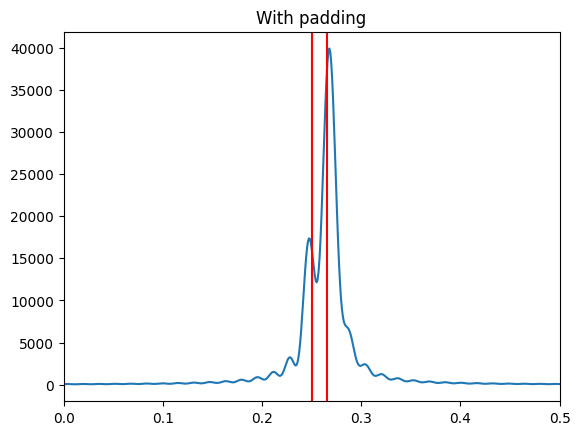

In [156]:
Nfft = 1024
fig, ax = plt.subplots()
plt.xlim([0,0.5])
ax.plot(np.linspace(0,1,Nfft),np.abs(np.fft.fft(x,Nfft))**2, label='FFT')
ax.axvline(x=f[0], color='red')
ax.axvline(x=f[1], color='red')
plt.title("With padding")
plt.show()

Dans les 2 cas, one ne peut pas séparer 2 fréquences différentes sur le periodogramme, ce qui montre bien que l'analyse de Fourier ne suffit pas ici.

---

## 3.2) High resolution methods
### Q1)

In [157]:
n=32
K=2
l=N+1-n

#utilisation fonction de Hankel
H=hankel(x[:n],x[l-1:])
print(H.shape)

Rxx=(1/l)*H@H.conj().T


(32, 32)


### Q2)

In [158]:
[U1,Lambda,U2]=np.linalg.svd(Rxx)

W=U1[:,:K]
print(W.shape)


(32, 2)


---

## 3.2.1)  ESPRIT method
### Q3)

In [159]:
Wdown=W[:n-1,:]
Wup=W[1:,:]

Phi=np.linalg.pinv(Wdown)@Wup

pole=np.linalg.eig(Phi)[0]
delta_estimated=np.log(abs(pole))
f_estimated=np.angle(pole)/(2*np.pi)
delta_estimated,f_estimated


(array([-5.00000000e-02, -2.22044605e-16]), array([0.26587302, 0.25      ]))

In [160]:
#On réecrit tout pour avoir une fonction
def ESPRIT(x,n,K):
    l=N-n+1

    H=hankel(x[:n],x[l-1:])
    Rxx= H @ H.conj().T  / l
    [U1,Lambda,U2]=np.linalg.svd(Rxx)
    
    W=U1[:,:K]

    Wdown=W[:-1,:]
    Wup=W[1:,:]

    Phi=np.linalg.pinv(Wdown)@Wup

    pole=np.linalg.eigvals(Phi)
    
    delta_estimated=np.log(np.abs(pole))
    f_estimated=np.angle(pole)/(2*np.pi)
    return(delta_estimated,f_estimated)

### Q4)

In [161]:
def LeastSquares(x,delta,f):
    N = len(x)
    K = len(delta) # K should also be len(f)
    z = np.exp(delta+2j*np.pi*f)
    V = np.zeros((N,K))
    V = 1j*V
    for i in range(N):
        for k in range(K):
            V[i,k] = z[k]**i
    alpha = np.linalg.pinv(V) @ x
    a = abs(alpha)
    phi = np.angle(alpha)
    return(a,phi)

print(delta_estimated,f_estimated)
LeastSquares(x,delta_estimated,f_estimated)
    

[-5.00000000e-02 -2.22044605e-16] [0.26587302 0.25      ]


(array([10.,  1.]), array([-0.23913734, -0.35642682]))

### Q5)

In [162]:
a_estimated,phi_estimated=LeastSquares(x,delta_estimated,f_estimated)

print('Fréquence de base : ' + str(f) + ', Calculé : ' + str(f_estimated[::-1]))
print('Difference : ' + str(f-f_estimated[::-1]))
print()
print('deltas dee base : ' + str(delta) + ', Calculé : ' + str(delta_estimated[::-1]))
print('Difference : ' + str(delta-delta_estimated[::-1]))
print()
print('amplitude de base : ' + str(a) + ', Calculé : ' + str(a_estimated[::-1]))
print('Difference : ' + str(a-a_estimated[::-1]))
print()
print('déphasage de base : ' + str(phi) + ', Calculé : ' + str(phi_estimated[::-1]))
print('Difference : ' + str(phi-phi_estimated[::-1]))


Fréquence de base : [0.25       0.26587302], Calculé : [0.25       0.26587302]
Difference : [0. 0.]

deltas dee base : [ 0.   -0.05], Calculé : [-2.22044605e-16 -5.00000000e-02]
Difference : [2.22044605e-16 3.40005801e-16]

amplitude de base : [ 1 10], Calculé : [ 1. 10.]
Difference : [-1.33226763e-15 -3.90798505e-14]

déphasage de base : [-0.3564268203054106, -0.2391373403616912], Calculé : [-0.35642682 -0.23913734]
Difference : [2.49800181e-15 1.11022302e-16]


On observe que les differences entre les coefficients estimé par la méthode ESPRIT avec ceux originaux sont minimes, ainsi la méthode est très efficace ici.

---

## 3.2.2) MUSIC Method

### Q5)

100%|██████████| 300/300 [00:02<00:00, 100.55it/s]


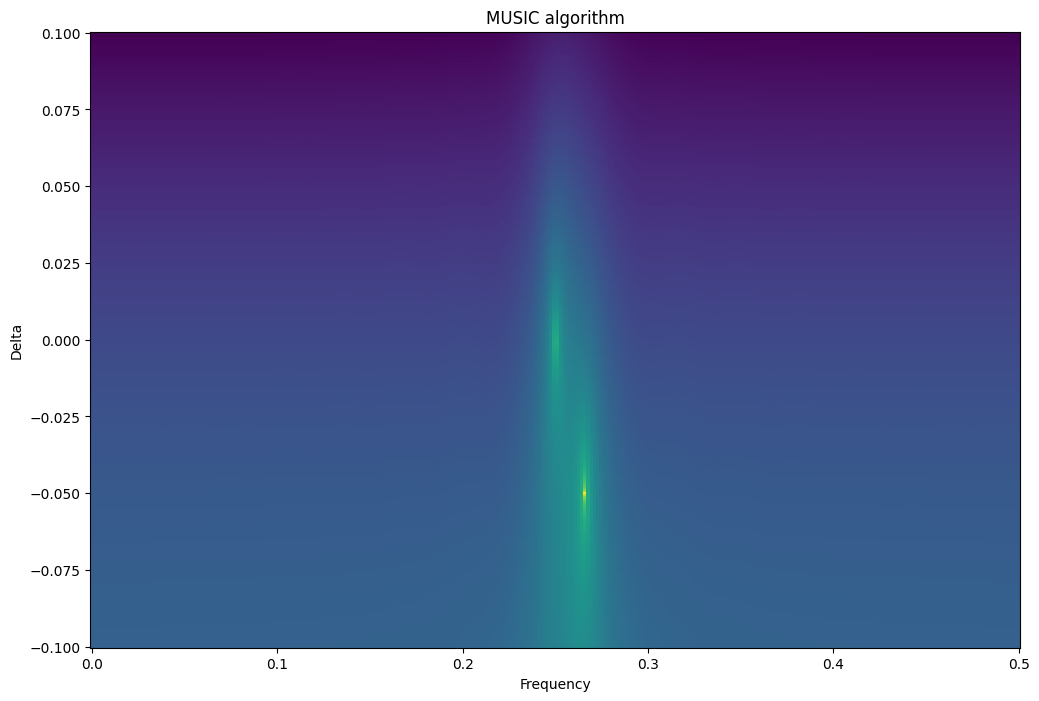

In [163]:
from tqdm import tqdm

def vn(d,f,n):

    ln_vn=(d+2*1j*np.pi*f)*np.arange(n)

    return np.exp(ln_vn)

def MUSIC(x,n,K):
    l=len(x)+1-n
    H=hankel(x[:n],x[l-1:])
    Rxx= H@H.conj().T  / l
    [U1,Lambda,U2]=np.linalg.svd(Rxx)
    
    W_noise=U1[:, K:]
    
    res=300
    fr=np.linspace(0,0.5,res)
    delt=np.linspace(-0.1,0.1,res)

    res=np.zeros((len(delt),len(fr)))
    for i in tqdm(range(len(res))):
        for j in range(len(res[0])):
            vn_value=np.matrix(vn(delt[i],fr[j],n)).T
            temp=W_noise.conj().T @ vn_value
            res[i][j]=np.log(1/np.sum(np.square(np.abs(temp))))

    
    fig = plt.figure(figsize=(12,8))
    #delt,fr=np.meshgrid(delt,fr)
    #ax = fig.add_subplot(111, projection='3d')
    ax= fig.add_subplot(111)
    ax.pcolormesh(fr, delt, res)
    ax.set_ylabel('Delta')
    ax.set_xlabel('Frequency')
    ax.set_label('MUSIC spectrum')
    ax.set_title('MUSIC algorithm')
    plt.show()

MUSIC(x,32,2)


Avec une résolution à partir de 200 on voit bien les 2 pics pour les deltas et fréquences correspondantes (0 et 0.25 puis -0,05 et environ 0.265)

---

---

# 4) Signal Audio
## 4.1)

In [164]:
from scipy.signal import find_peaks
from scipy.io import wavfile

In [165]:
T, data1, nframes, nchannels, sampling_frequency = read_values('ClocheA.WAV')

In [166]:
n = len(data1)
x1 = np.array(data1)
len_x = x1.shape[1]
x1 = x1.reshape(len_x)

fs=1
n = len(x1)
f = np.fft.rfftfreq(n, 1/fs)
fft = np.fft.rfft(x)
psd = np.abs(fft)**2/n

#à la main on estime le fondamental à 456 Hz
fmain = (f[:n//2])[list(psd[:n//2]).index(max(psd[:n//2]))]
plt.figure(figsize=(10, 5))
plt.semilogy(f[:n//2], psd[:n//2], label='Spectral Density')

plt.axvline(x=fmain, color='black', linestyle='--', label='fundamental')
plt.axvline(x=fmain/2, color='g', linestyle='--', label='bourdon')
plt.axvline(x=fmain*1.2, color='y', linestyle='--', label='minor third')
plt.axvline(x=fmain*1.5, color='b', linestyle='--', label='fifth')
plt.axvline(x=fmain*2, color='red', linestyle='--', label='octave')
plt.axvline(x=fmain*2.5, color='red', linestyle='--')
plt.axvline(x=fmain*2.6, color='red', linestyle='--')
plt.axvline(x=fmain*2.7, color='red', linestyle='--')
plt.axvline(x=fmain*3, color='red', linestyle='--')
plt.axvline(x=fmain*3.3, color='red', linestyle='--')
plt.axvline(x=fmain*3.7, color='red', linestyle='--' )
plt.axvline(x=fmain*4.2, color='red', linestyle='--')

plt.legend()
plt.title('Periodogram ClocheA')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid(True)
plt.show()


TypeError: ufunc 'rfft_n_odd' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
T, data2, nframes, nchannels, sampling_frequency = read_values('ClocheB.WAV')

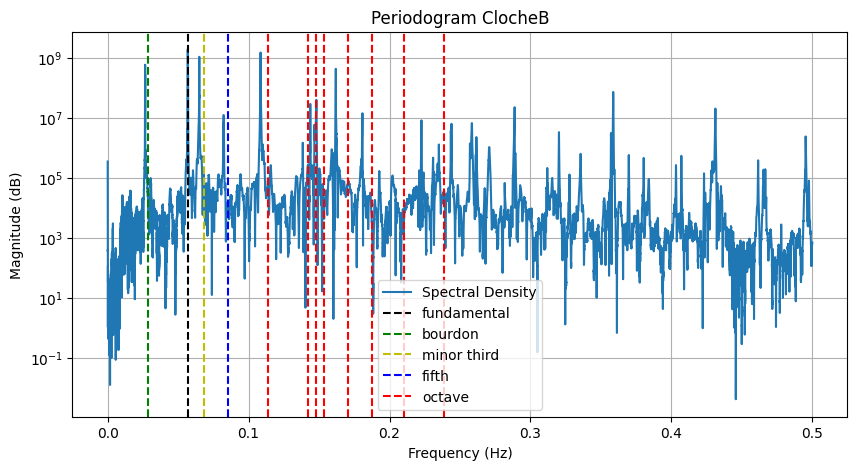

In [ ]:
n = len(data2)
x2 = np.array(data2)
len_x = x2.shape[1]
x2 = x2.reshape(len_x)

fs=1
n = len(x2)
f = np.fft.rfftfreq(n, 1/fs)
fft = np.fft.rfft(x2)
psd = np.abs(fft)**2/n

#à la main on estime le fondamental à 456 Hz
fmain = (f[:n//2])[list(psd[:n//2]).index(max(psd[:n//2]))]
plt.figure(figsize=(10, 5))
plt.semilogy(f[:n//2], psd[:n//2], label='Spectral Density')

plt.axvline(x=fmain, color='black', linestyle='--', label='fundamental')
plt.axvline(x=fmain/2, color='g', linestyle='--', label='bourdon')
plt.axvline(x=fmain*1.2, color='y', linestyle='--', label='minor third')
plt.axvline(x=fmain*1.5, color='b', linestyle='--', label='fifth')
plt.axvline(x=fmain*2, color='red', linestyle='--', label='octave')
plt.axvline(x=fmain*2.5, color='red', linestyle='--')
plt.axvline(x=fmain*2.6, color='red', linestyle='--')
plt.axvline(x=fmain*2.7, color='red', linestyle='--')
plt.axvline(x=fmain*3, color='red', linestyle='--')
plt.axvline(x=fmain*3.3, color='red', linestyle='--')
plt.axvline(x=fmain*3.7, color='red', linestyle='--' )
plt.axvline(x=fmain*4.2, color='red', linestyle='--')
plt.legend()

plt.title('Periodogram ClocheB')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid(True)
plt.show()

On remarque dans les 2 cas que les pics données dans l'ennoncé correspondent à peu près à ceux sur notre graphe (en tout cas pour les premiers, ensuite la correspondance est de moins en moins bonne)

---

## 4.2)

In [ ]:
K=54
n=512
l=1024
N= n + l - 1 #1535
sample=x1[10000:10000+N]

delta,f=ESPRIT(sample,n,K)
delta = np.real(delta)
a,phi=LeastSquares(sample,delta,f)
delta1=[]
for i in range (len(delta)):
    if delta[i] > 0:
        delta[i] = -0.0001

np.amax(delta)

np.float64(-5.169236726265268e-05)

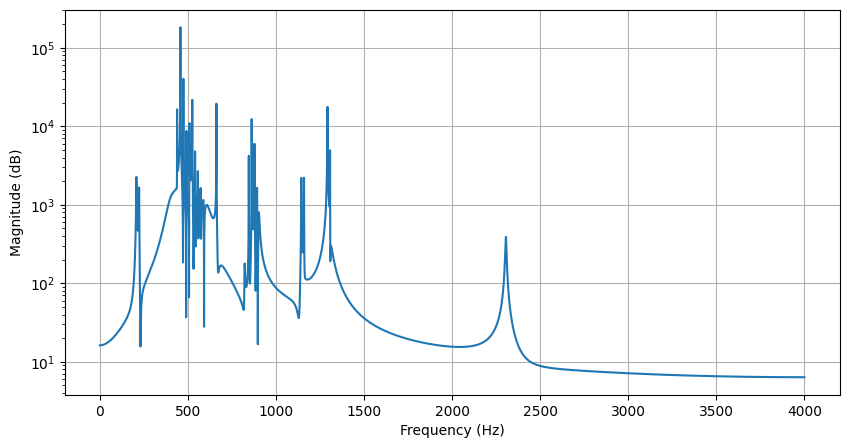

In [ ]:
durée = 5
N2= Fs * durée
x_synthesised=Synthesis(N2,delta,f,a,phi)

Nfft = N2
X_synthesised = np.fft.fft(x_synthesised, Nfft)
f_axis = np.linspace(0, fs2, Nfft)

plt.figure(figsize=(10, 5))
plt.plot(f_axis[:Nfft//2],np.abs(X_synthesised[:Nfft//2]))
plt.semilogy()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid(True)
plt.show()


100%|██████████| 200/200 [02:29<00:00,  1.33it/s]


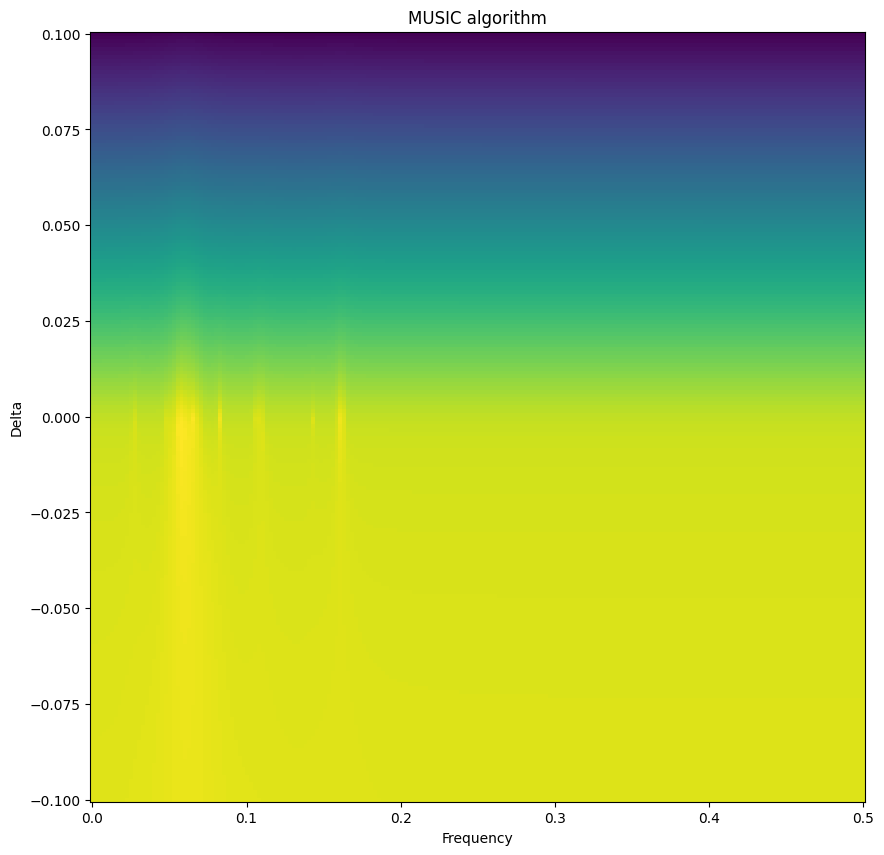

In [ ]:
MUSIC(x_synthesised,n,K)

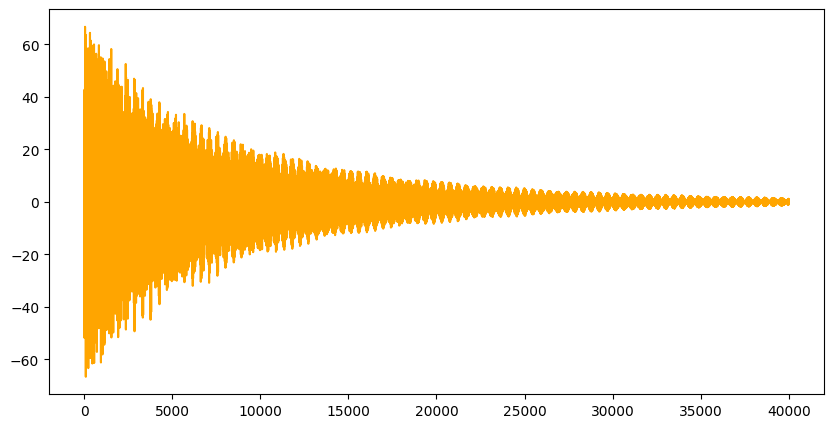

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(np.real(x_synthesised), color='orange')
plt.show()

In [167]:
IPython.display.Audio(np.real(x_synthesised), rate=Fs)

Le résultat est très convenable.